In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.api as sm

from analyzer.metric import MetricCalculator
from analyzer.model.regression_model import RegressionModel
from data.io import Reader
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from keras.src.layers import Dense
from keras import Sequential, Input
import pymc as pm

# Постановка задачи
1. Провести анализ датасета 
2. Построить модель для предсказания price

датасет:
https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_SVM_Furniture_Price.csv

# Проверка целостности датасета

In [118]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_SVM_Furniture_Price.csv")
df = df_original.copy().reset_index(drop=True)
df.head(10)

price        cost  sales  profit_margin  inventory  \
0  279.239958  180.369183     19      35.407101         69   
1  469.412647  279.194123     15      40.522667        171   
2  492.070378  282.575686     10      42.574132         83   
3  486.235545  429.466185      7      11.675280        150   
4  191.933103  140.628360     22      26.730534        168   
5  250.656218  153.147408     28      38.901413        157   
6  485.819950  433.841349     24      10.699149         70   
7  166.049458  122.008925     13      26.522540        113   
8  195.655656  121.916626     19      37.688167         13   
9   60.472371   35.187182     13      41.812796        144   

   discount_percentage  delivery_days category material  color  location  \
0             2.482052              4     Sofa     Wood  White     Urban   
1             8.590982              4     Desk    Glass  Brown     Urban   
2             1.827367              5    Chair     Wood  Brown     Rural   
3            21.235863              8      Bed    Metal    Red     Rural   
4            14.376488              4      Bed     Wood  Black  Suburban   
5            25.023763              8     Desk   Fabric  White     Rural   
6            26.002920              1      Bed   Fabric  Black     Rural   
7            16.017853              8     Desk    Metal   Blue  Suburban   
8            10.155799              2     Desk  Plastic  White     Rural   
9            16.137586              4    Table     Wood  Black     Rural   

   season store_type   brand      revenue  
0  Winter     Online  BrandA  8866.028455  
1    Fall     Online  BrandC  6006.397661  
2  Winter     Online  BrandD  3633.914756  
3    Fall     Online  BrandB -5587.907063  
4  Spring     Online  BrandA  7290.472004  
5    Fall     Online  BrandD   813.830381  
6  Winter     Retail  BrandA  6902.246135  
7  Spring     Online  BrandB -5726.889872  
8  Winter     Retail  BrandA  6244.362619  
9  Winter     Retail  BrandD -3547.192034

In [119]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   int64  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   int64  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   int64  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), int64(3), object(7)
mem

In [120]:
# посмотрим на пропуски в данных
df.isna().sum()

price                  0
cost                   0
sales                  0
profit_margin          0
inventory              0
discount_percentage    0
delivery_days          0
category               0
material               0
color                  0
location               0
season                 0
store_type             0
brand                  0
revenue                0
dtype: int64

In [121]:
# Посмотрим статистику о датасете
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

# Оптимизируем датасет

In [122]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   int64  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   int64  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   int64  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), int64(3), object(7)
mem

In [123]:
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

In [124]:
df['sales'] = df['sales'].astype('uint8')
df['inventory'] = df['inventory'].astype('uint8')
df['delivery_days'] = df['delivery_days'].astype('uint8')

In [125]:
# проверяем
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   uint8  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   uint8  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   uint8  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), object(7), uint8(3)
mem

Выводы:
1. float данные не удаётся преобразовать менее, чем float64
2. int данные удаётся конвертировать в uint8 (без отрицательных значений)
3. категории парсятся из object в category

# Проводим первичный визуальный анализ зависимостей данных

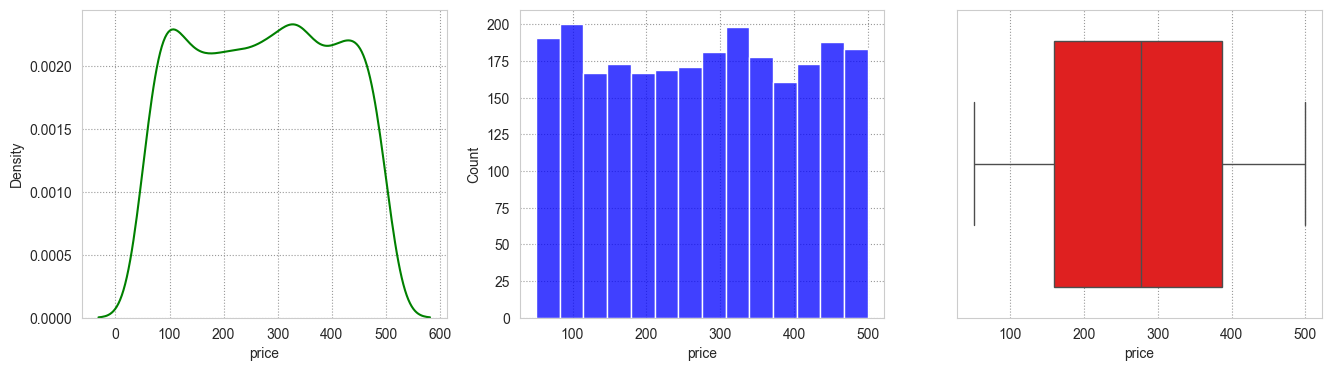

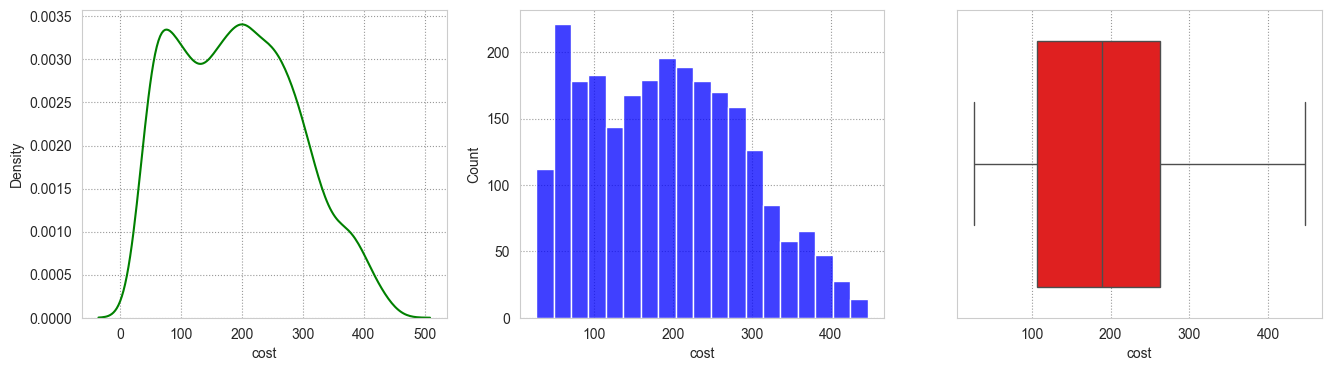

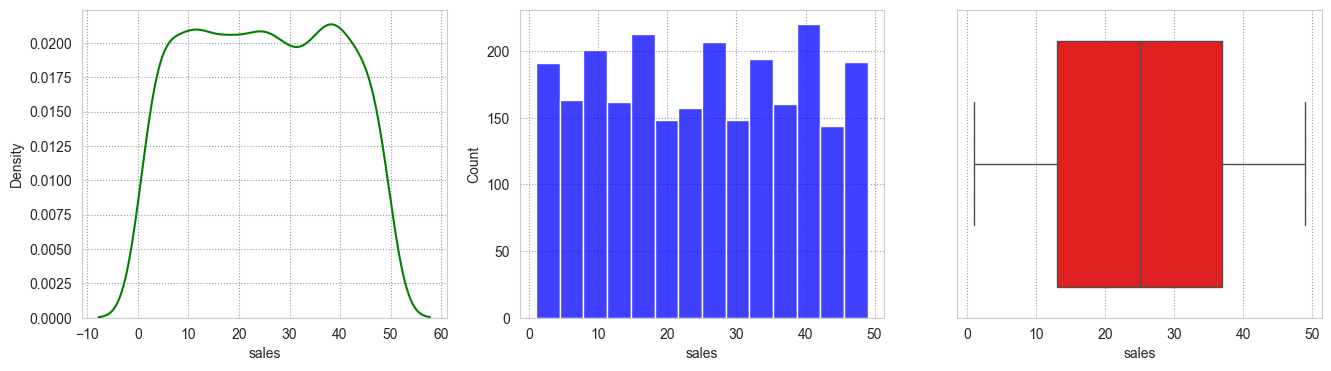

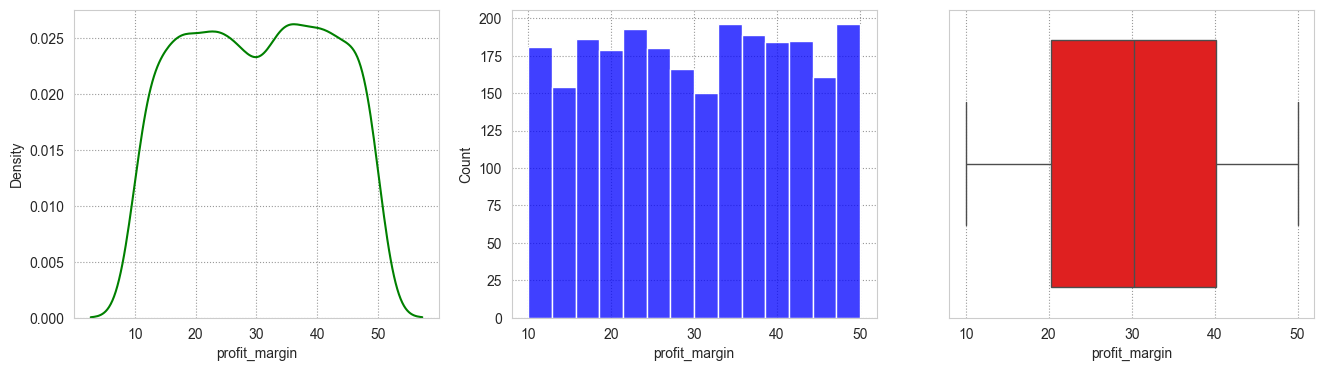

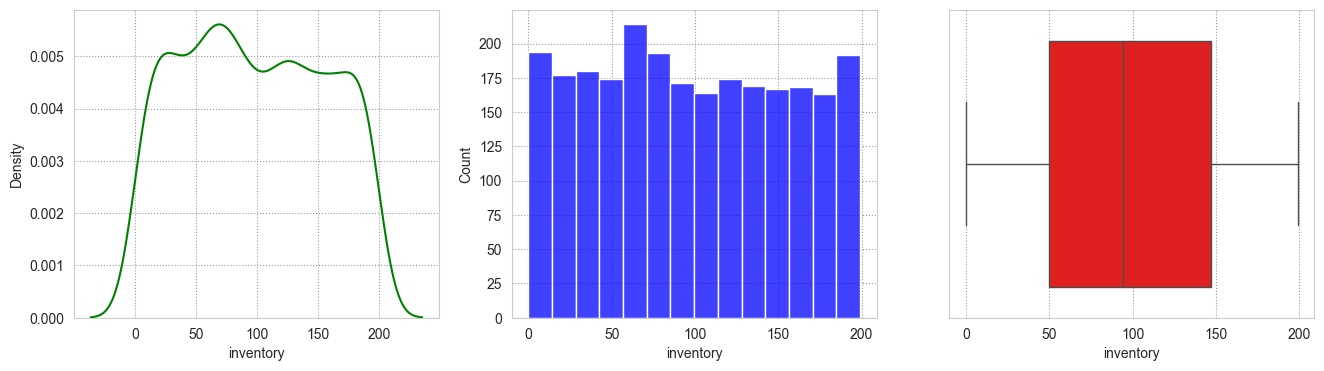

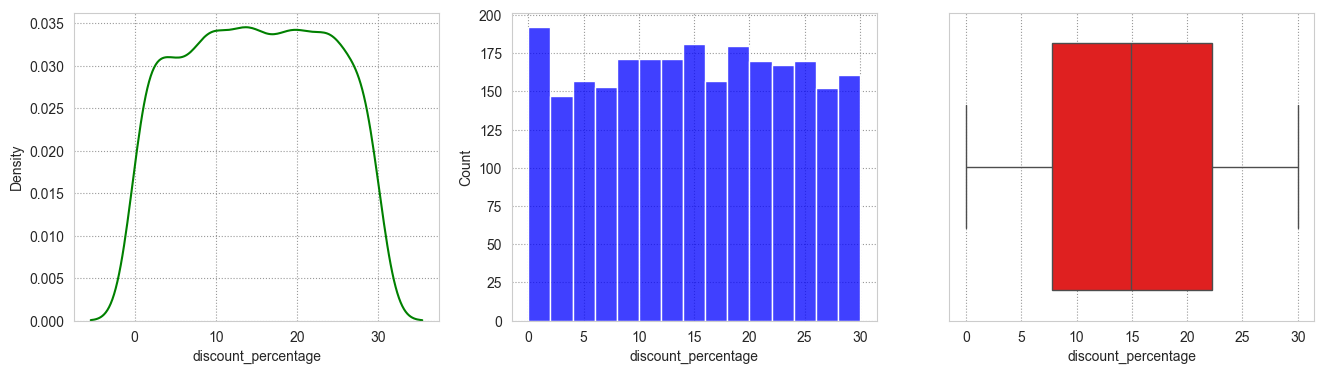

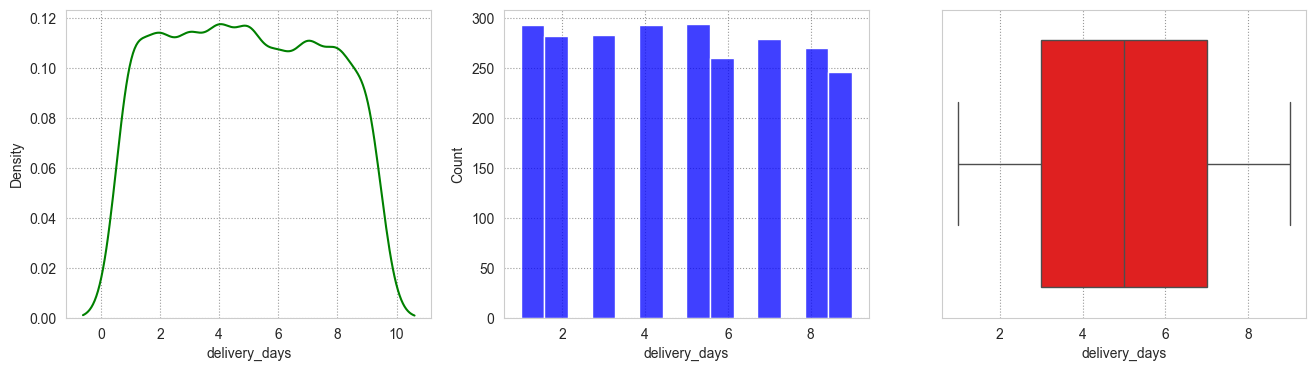

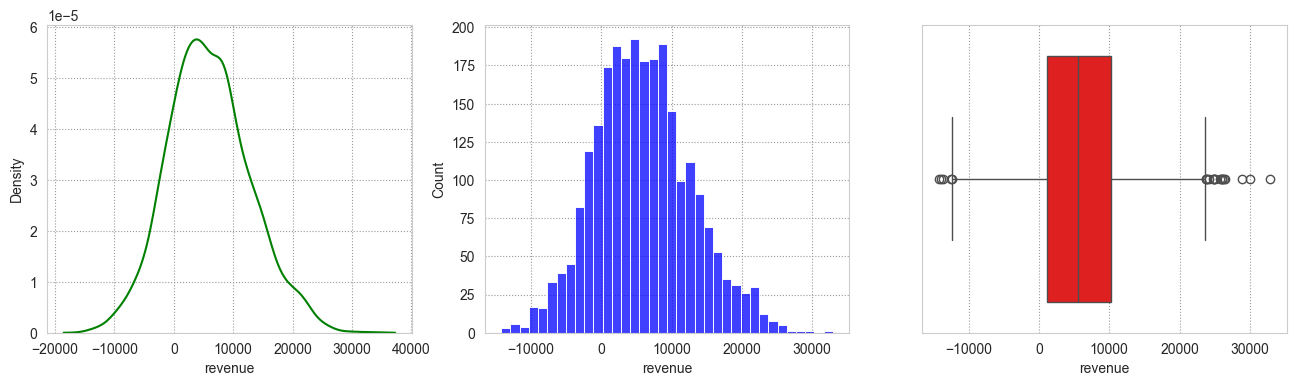

In [127]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

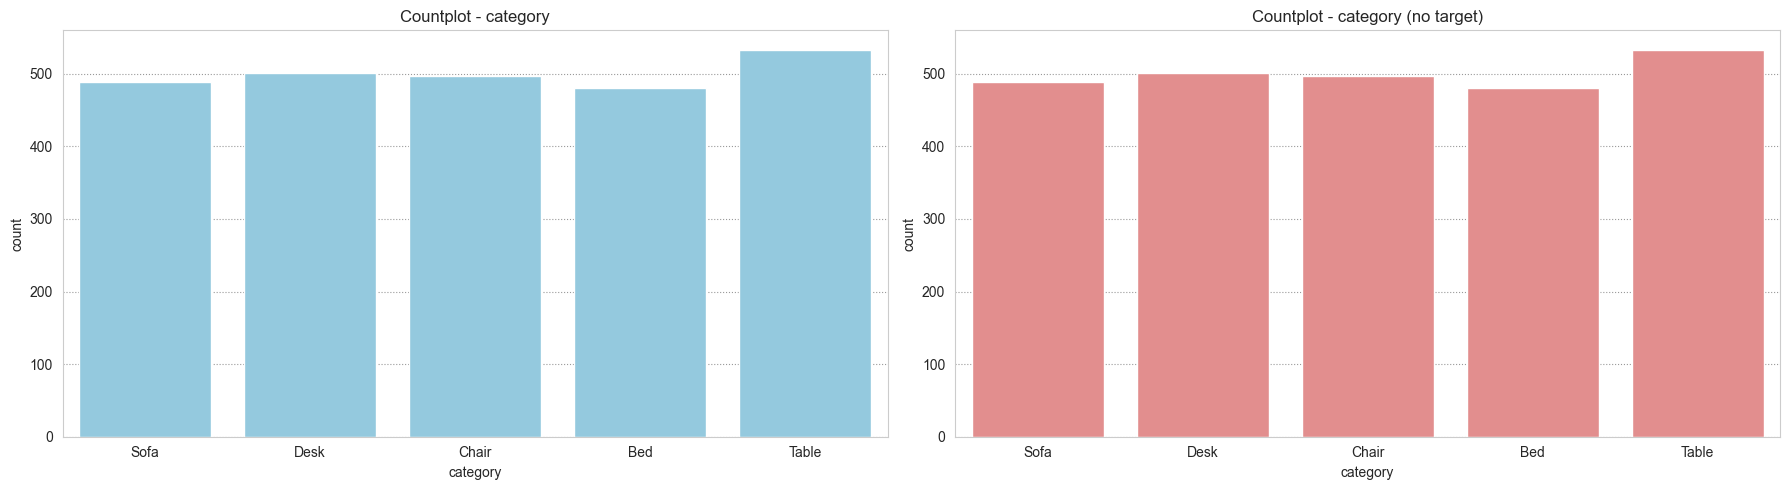

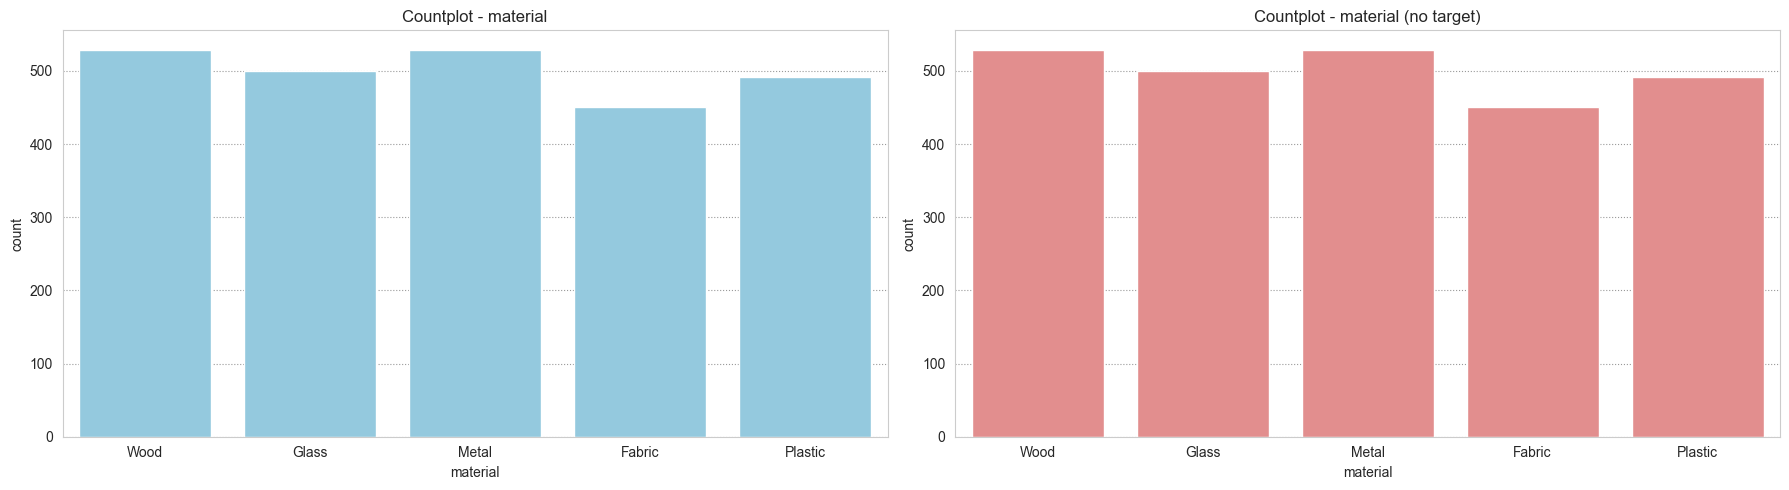

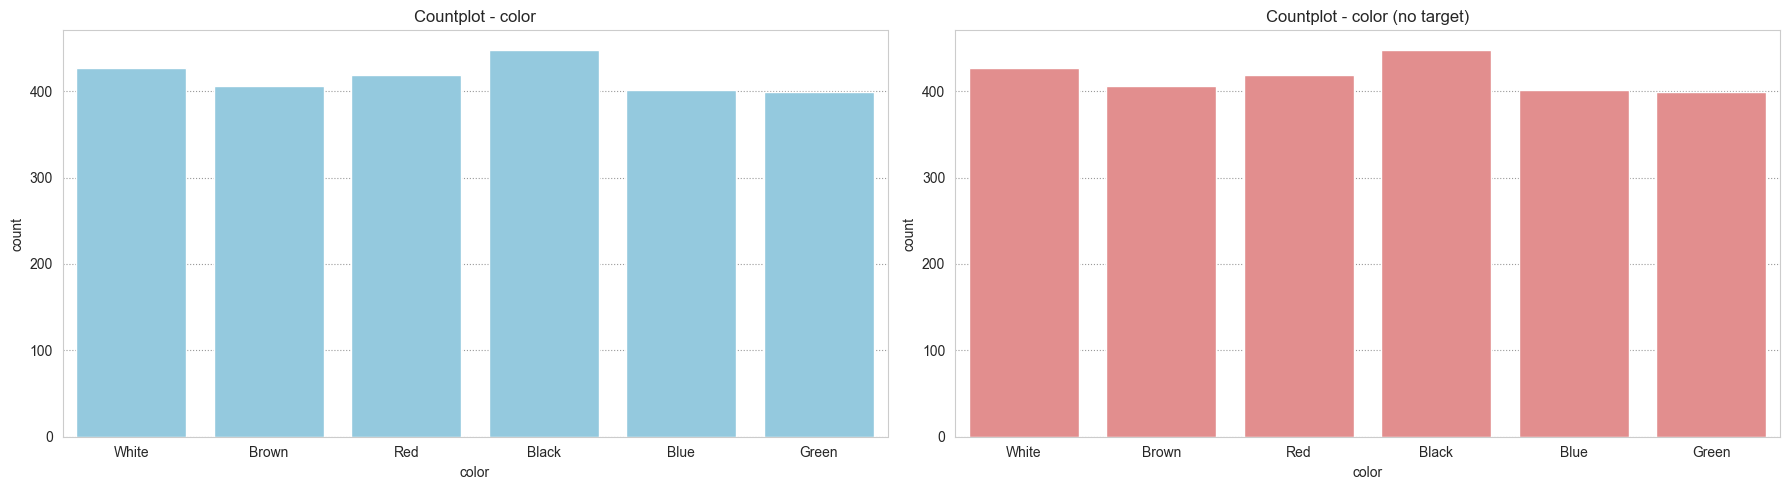

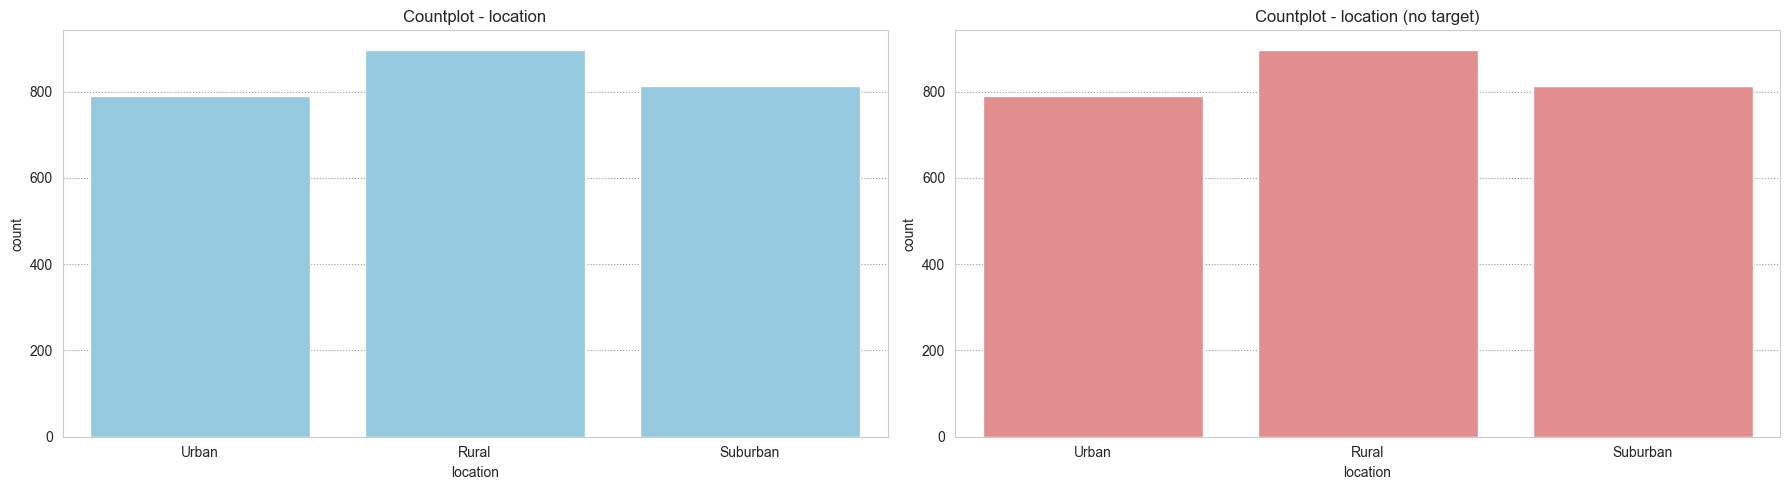

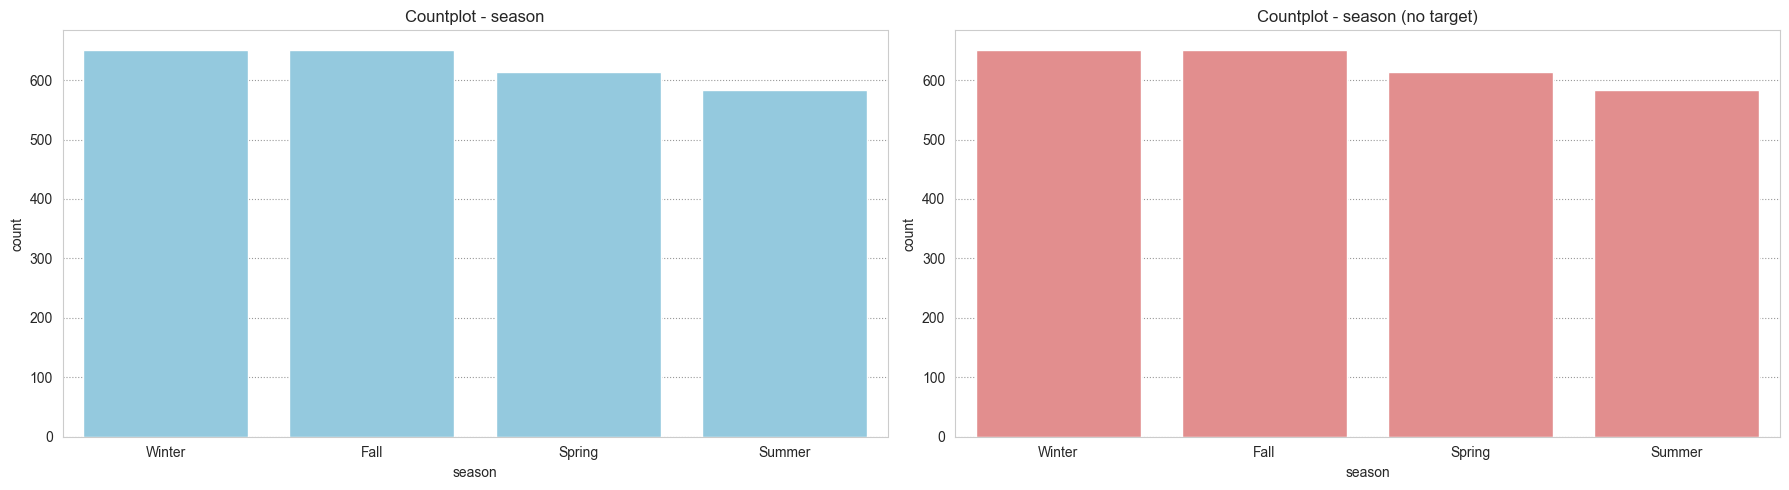

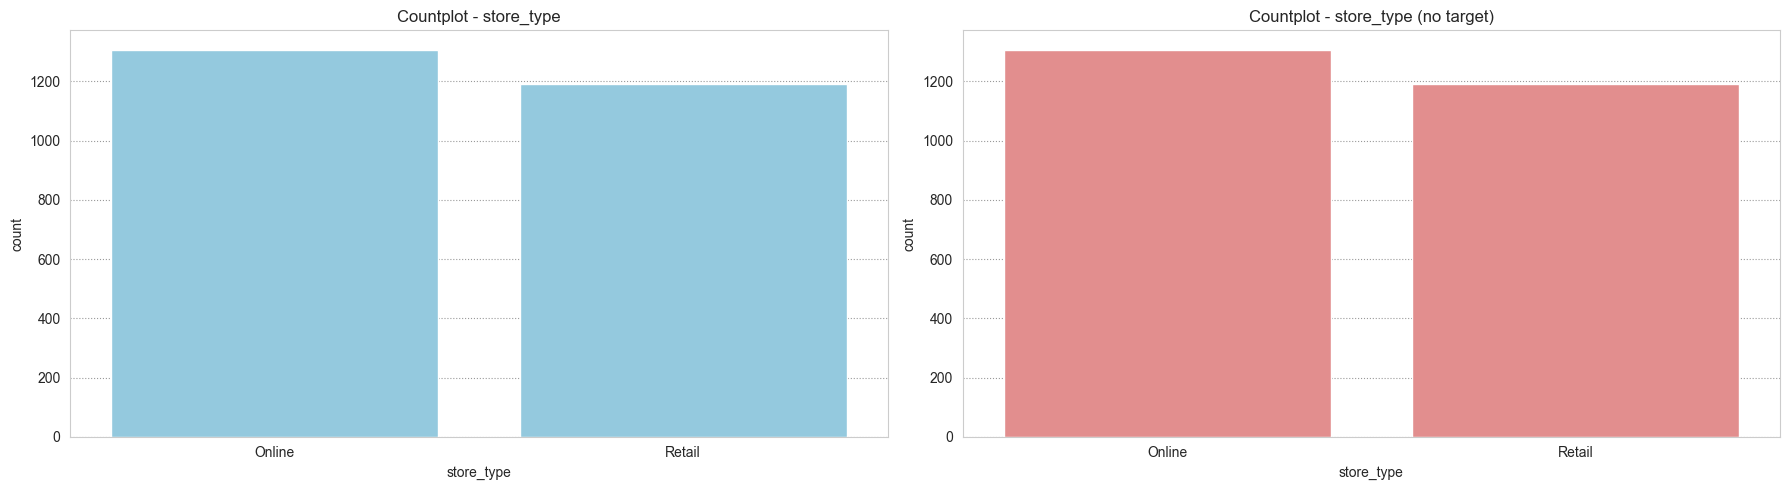

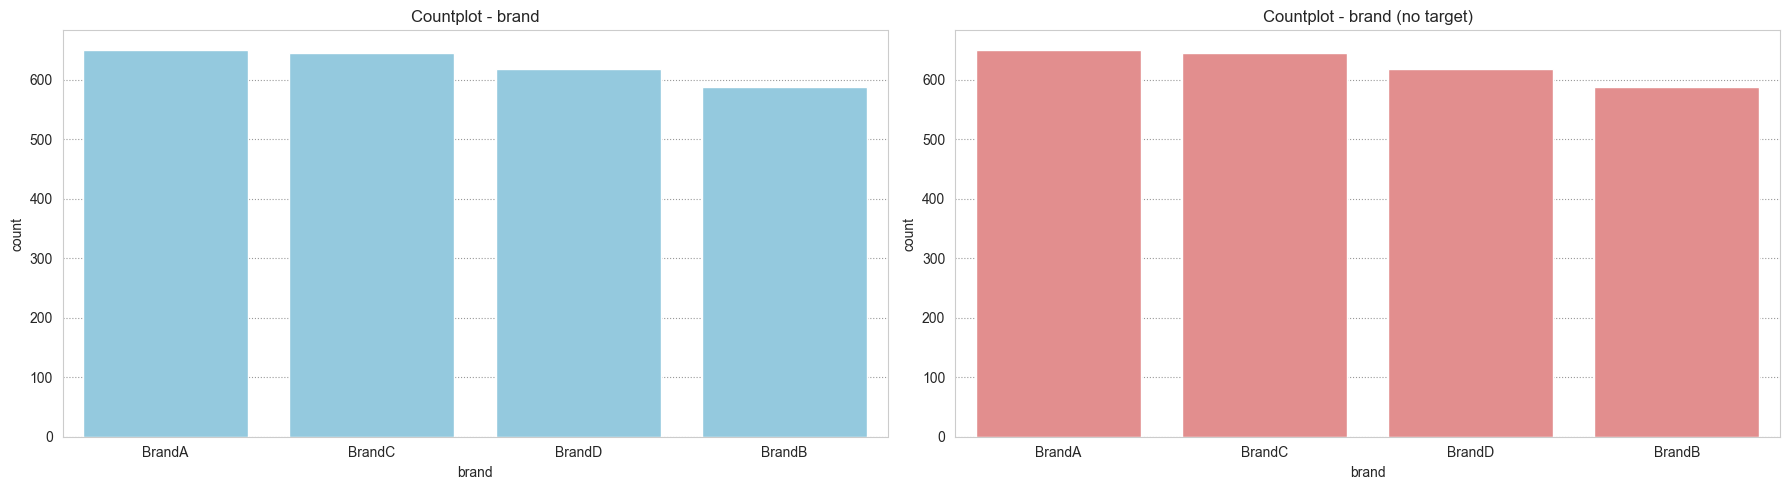

In [128]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

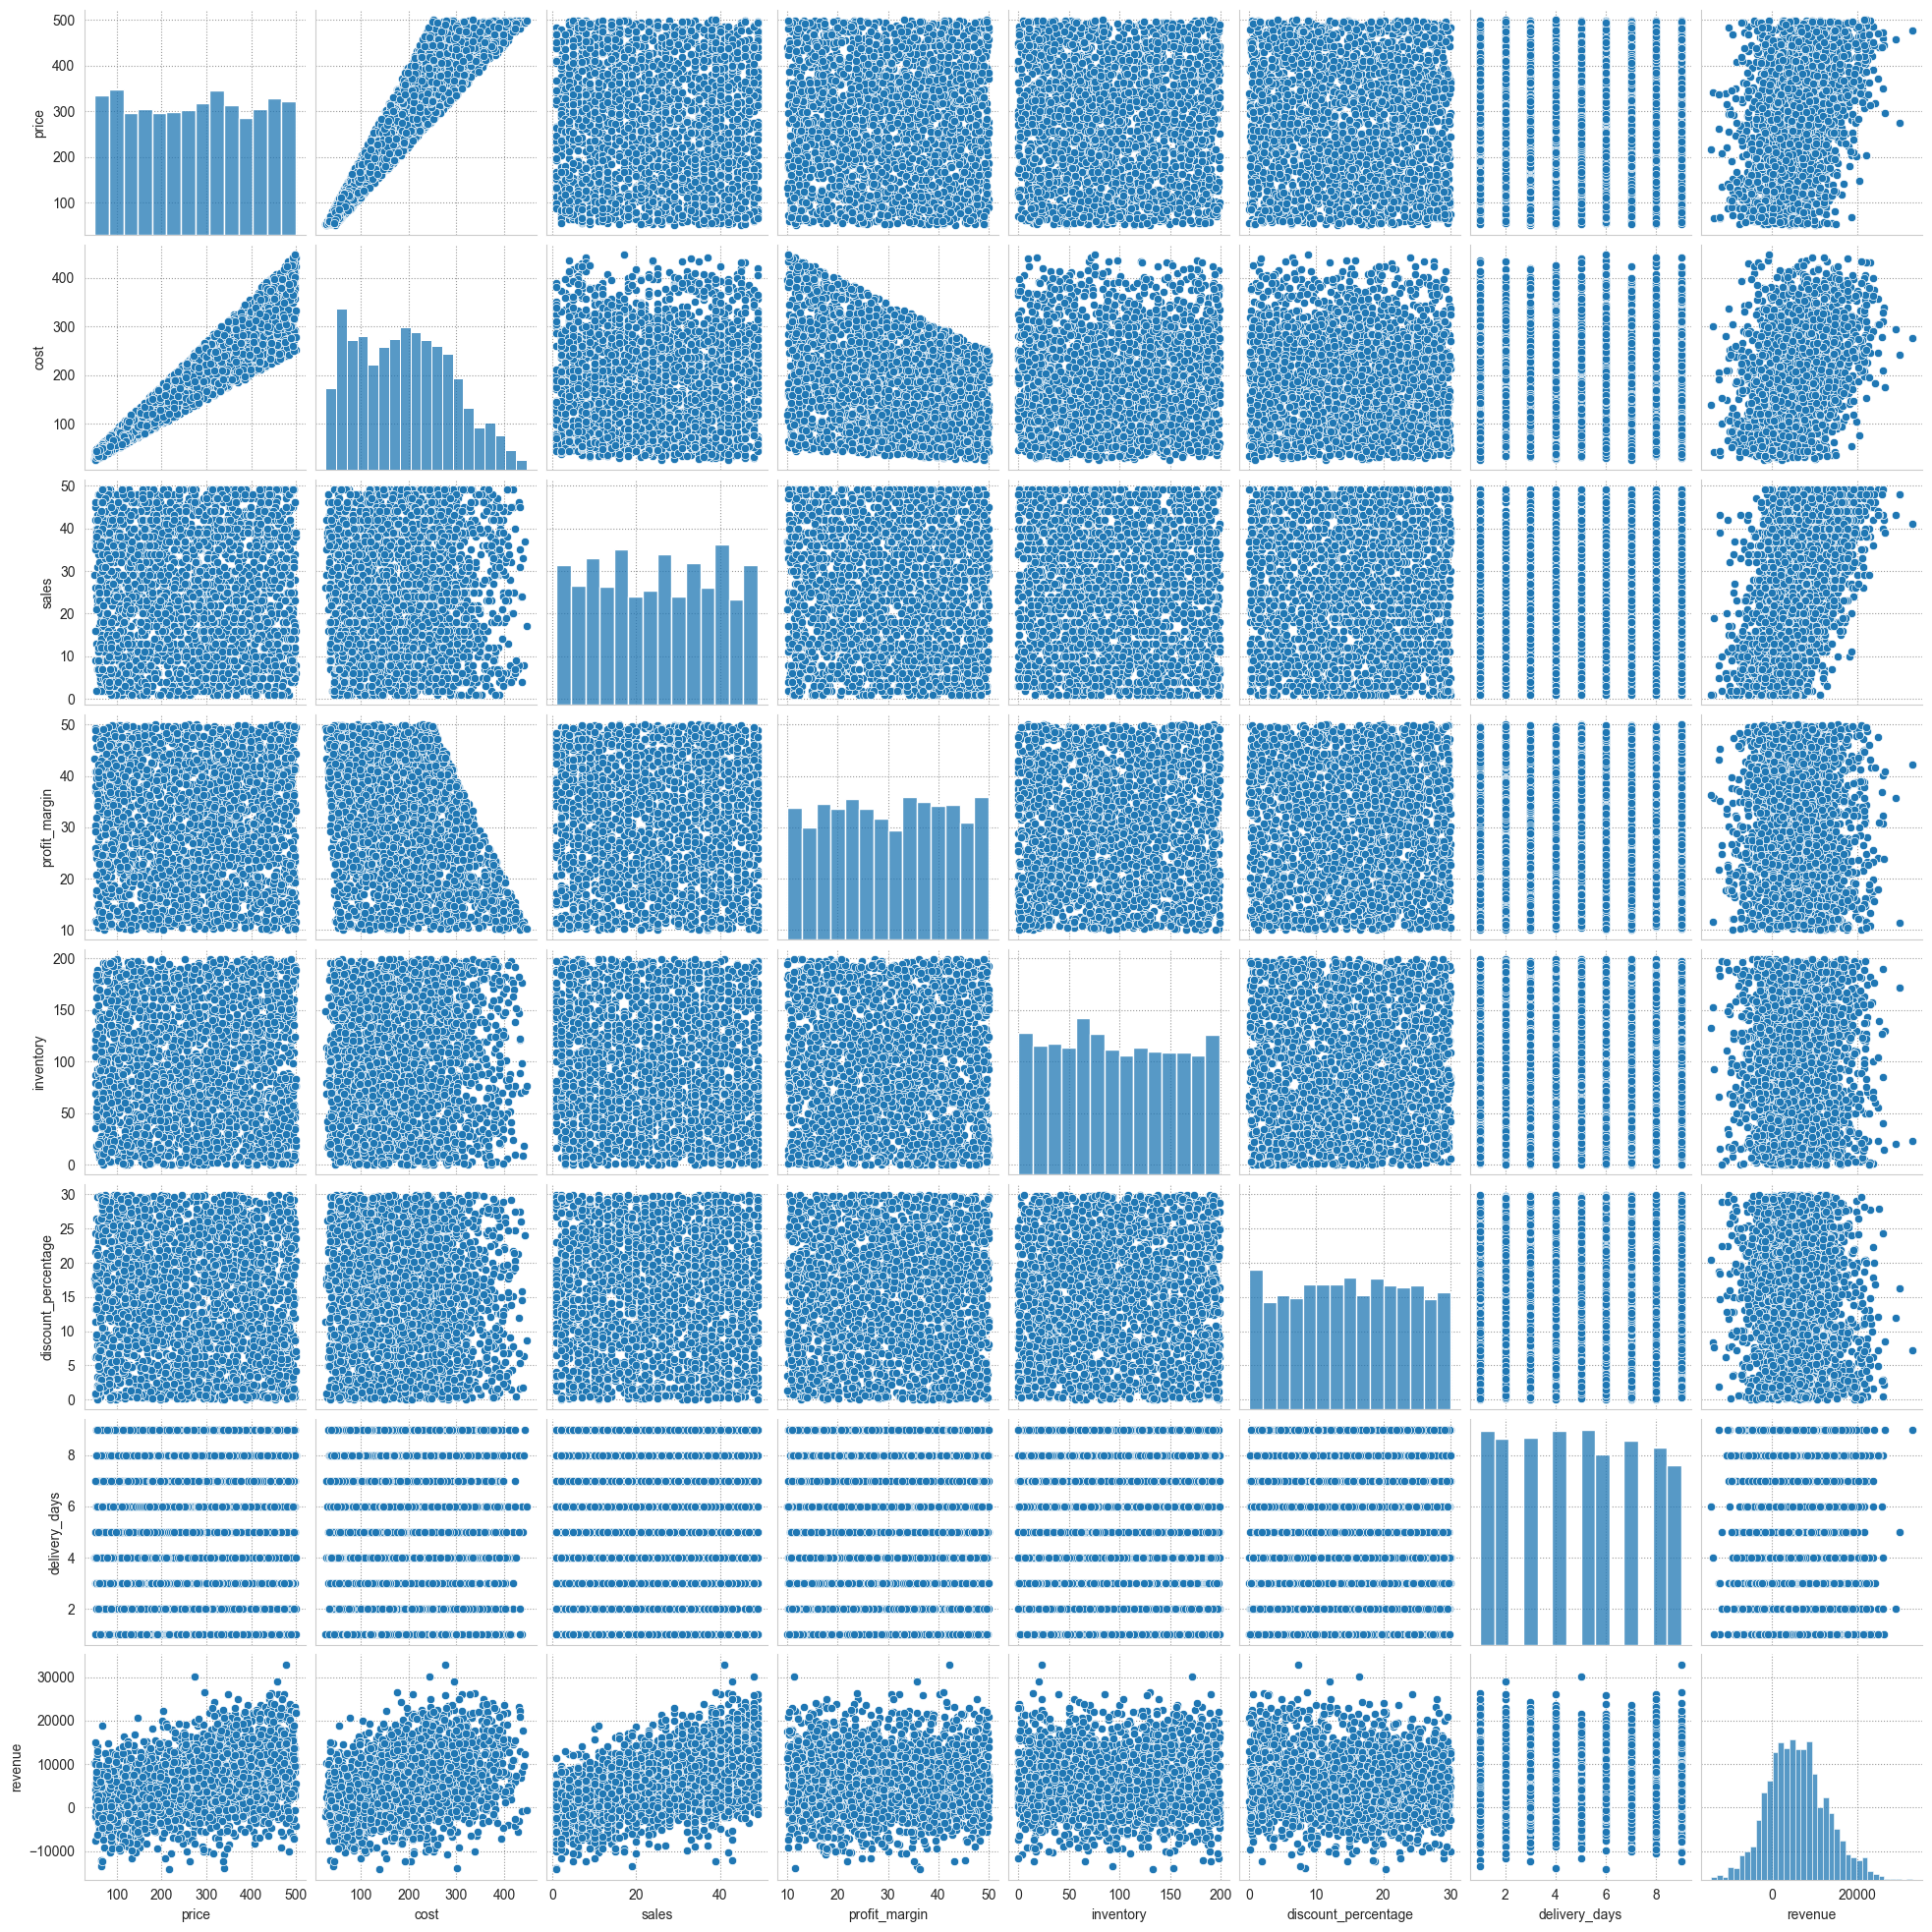

In [129]:
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

Выводы:
1. cost и revenue имеют близкое к нормальному распределению
2. выше определённого значения cost начинает падает profit_margin
3. подозрения на прямую корреляцию price (таргета) от cost
4. распределения price и cost не равны 

# Проводим оценку зависимостей

## стат.обработка непрерывных данных

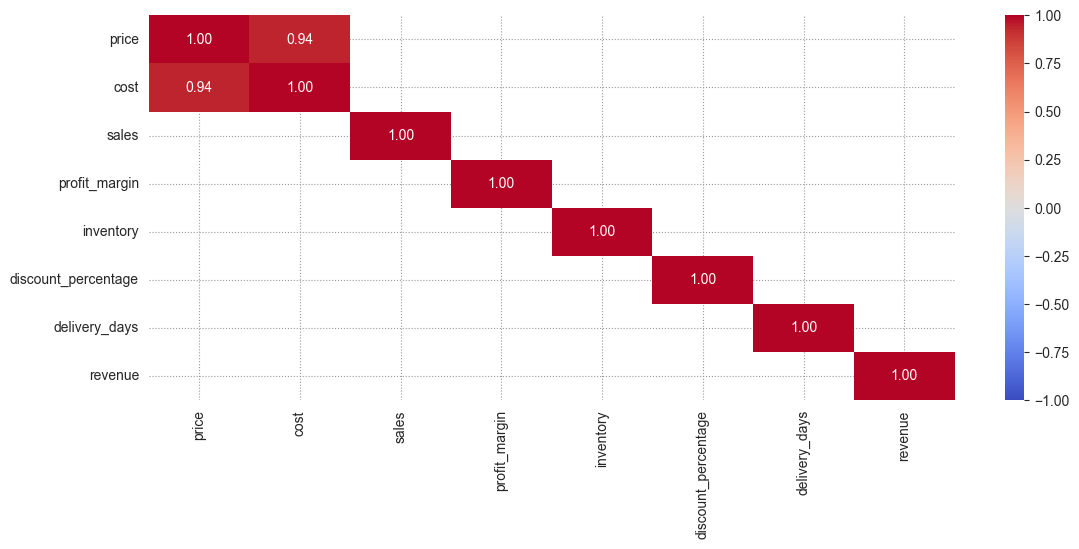

In [130]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(df, method='spearman', boundary=0.5)

In [131]:
# проверяем распределения между таргетом и признаками
for column in df.select_dtypes(include='number').columns:
    print(f"{column} и price:")
    groups = [df[column], df['price']]
    StatCriteria().mannwhitneyu(groups)

price и price:
Mann-Whitney U test
U_statistic = 3125000.000
Распределения двух выборок равны (p-value = 1.000).
cost и price:
Mann-Whitney U test
U_statistic = 1987986.000
Распределения двух выборок не равны (p-value = 0.000).
sales и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
profit_margin и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
inventory и price:
Mann-Whitney U test
U_statistic = 778193.000
Распределения двух выборок не равны (p-value = 0.000).
discount_percentage и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
delivery_days и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
revenue и price:
Mann-Whitney U test
U_statistic = 4972244.000
Распределения двух выборок не равны (p-value = 0.000).


In [132]:
# Проверим допущение о мультиколлинеарности признаков
exclude_features = ['price']
StatCriteria().VIF(df, exclude_features)

VIF
cost                 4.416676
sales                4.864945
profit_margin        5.206018
inventory            3.584181
discount_percentage  3.675485
delivery_days        4.153730
revenue              2.707721

Выводы:
1. сильная положительная корреляция price и cost
2. profit_margin с VIF > 5 намекает на некоторую мультиколлениарность
3. распределения непрерывных признаков и таргета не совпадают

## стат.обработка категориальных данных

In [133]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

category material  color location  season store_type   brand
count      2500     2500   2500     2500    2500       2500    2500
unique        5        5      6        3       4          2       4
top       Table    Metal  Black    Rural  Winter     Online  BrandA
freq        533      529    448      897     651       1307     650

Chi-square test
chisq_statistic = 10.426, dof = 16.000
Две переменные независимы (p-value = 0.843).
Chi-square test
chisq_statistic = 17.471, dof = 20.000
Две переменные независимы (p-value = 0.622).
Chi-square test
chisq_statistic = 5.572, dof = 8.000
Две переменные независимы (p-value = 0.695).
Chi-square test
chisq_statistic = 17.272, dof = 12.000
Две переменные независимы (p-value = 0.140).
Chi-square test
chisq_statistic = 7.275, dof = 4.000
Две переменные независимы (p-value = 0.122).
Chi-square test
chisq_statistic = 10.448, dof = 12.000
Две переменные независимы (p-value = 0.577).
Chi-square test
chisq_statistic = 10.426, dof = 16.000
Две переменные независимы (p-value = 0.843).
Chi-square test
chisq_statistic = 27.980, dof = 20.000
Две переменные независимы (p-value = 0.110).
Chi-square test
chisq_statistic = 13.374, dof = 8.000
Две переменные независимы (p-value = 0.100).
Chi-square test
chisq_statistic = 7.905, dof = 12.000
Две переменные независимы (p-value = 0.793).
Chi-sq

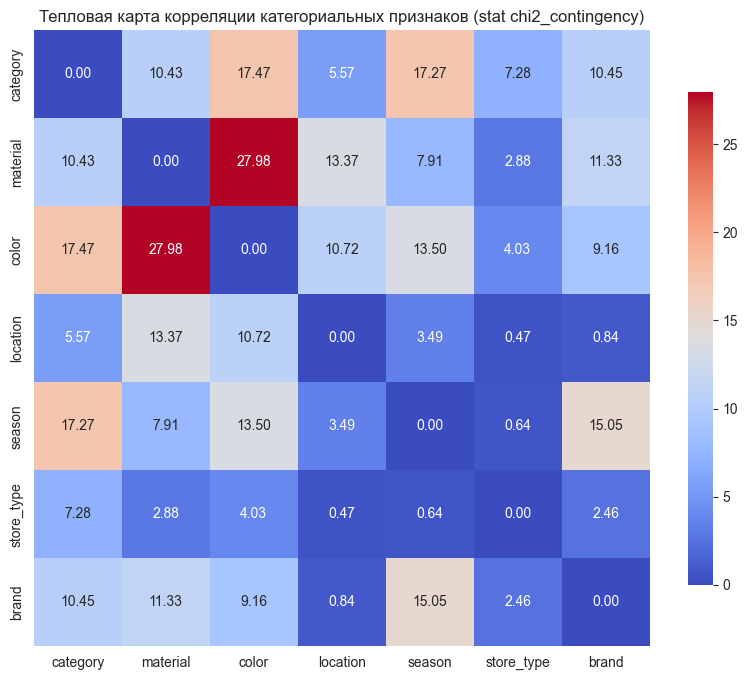

In [134]:
# Построим тепловую карту с категориальными переменными по хи-квадрат
Drawer.plot_heatmap_category(df)

Выводы:
1. небольшая зависимость категориальных признаков color и material
2. в категориальных данных нет большого числа уникальных значений
3. нет порядковых категориальных данных
4. store_type имеет два уникальных значения, можно использовать бинарную кодировку
5. season имеет циклические значения времён кода - циклическую кодировку
6. category, material, color, location, brand - подходят под one hot encoder

# Подготавливаем данные

In [135]:
# кодируем данные общего датасета
Encoder.booleanOneColumnEncoder(df['store_type'], 'Online')

0       1
1       1
2       1
3       1
4       1
       ..
2495    1
2496    0
2497    0
2498    0
2499    1
Name: store_type, Length: 2500, dtype: uint8

In [136]:
# разделяем данные
target = ['price']
# exclude_features = ['price']
exclude_features = ['price', 'profit_margin']  ## VIF profit_margin = 5.2

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

X_train, X_test, _ = Encoder.targetEncoder(X_train, X_test, y_train, columns_for_encoding)

# проводим нормализацию
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

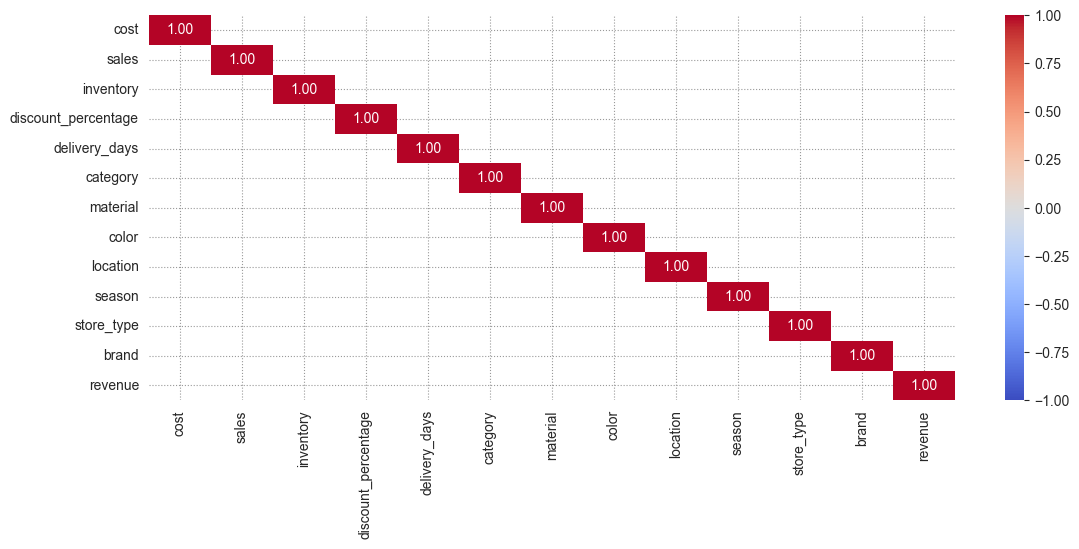

In [137]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(X_train, method='spearman', boundary=0.5)

In [138]:
# Применим метод Lasso для оценки признаков
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

__________
Коэффициенты Lasso-регрессии:
                Feature  Coefficient
0                  cost   496.483982
1                 sales   -20.451386
2             inventory    10.398502
3   discount_percentage    -0.940658
4         delivery_days    -0.997445
5              category     1.769861
6              material    -0.523861
7                 color    -2.023777
8              location     3.192034
9                season     0.980764
10           store_type     3.333947
11                brand    -0.674908
12              revenue    71.359995
R²: 0.866
MAE: 37.69
MAPE: 16%
RMSE: 47
MSE: 2247


Выводы:
1. кодировка произведена
2. тепловая карта корреляции после кодировки в порядке

In [139]:
# разделяем данные
target = ['price']
exclude_features = ['price']
# exclude_features = ['price', 'profit_margin']

df_copy = df.copy().reset_index(drop=True)
df_copy['price'] = df_copy['price']/1_000

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df_copy, exclude_features, target)

# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

X_train, X_test, _ = Encoder.oneHotEncoder(X_train, X_test, columns_for_encoding)

# проводим нормализацию
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

# Находим модель

## линейная регрессия

In [140]:
# Применим метод OLS
y_test, y_pred, model_lr = RegressionModel().OLS(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2273.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:34:03   Log-Likelihood:                 4528.5
No. Observations:                1875   AIC:                            -8997.
Df Residuals:                    1845   BIC:                            -8831.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cost                    0.5805    

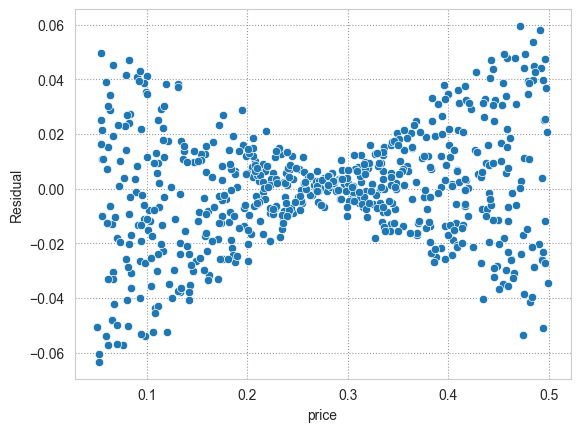

Shapiro-Wilk Test
statistic = 0.991
Данные не соответствуют нормальному распределению (p-value = 0.001).


In [141]:
# Проверка на гомоскедастичность визуально
residuals = y_test - y_pred
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()
StatCriteria().shapiro(residuals)

## метод опорных векторов

In [142]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.976
MAE: 0.02
MAPE: 8%
RMSE: 0
MSE: 0


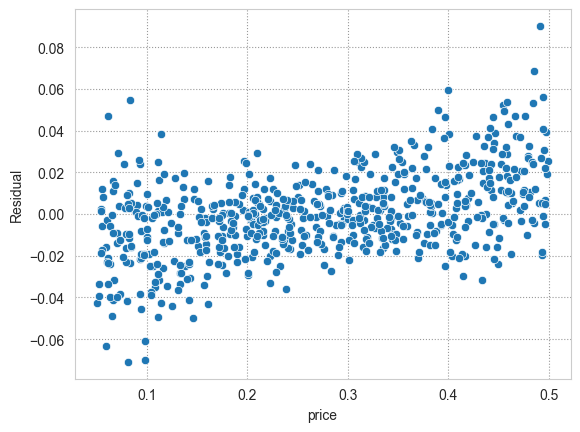

In [143]:
residuals = y_test - y_pred
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

## метод нейронных сетей

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - R2Score: -1.8826 - loss: 0.0481 - val_R2Score: 0.2285 - val_loss: 0.0131
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.4070 - loss: 0.0102 - val_R2Score: 0.5530 - val_loss: 0.0076
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.6649 - loss: 0.0059 - val_R2Score: 0.6871 - val_loss: 0.0053
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.7820 - loss: 0.0036 - val_R2Score: 0.7932 - val_loss: 0.0035
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.8484 - loss: 0.0026 - val_R2Score: 0.8387 - val_loss: 0.0027
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.8737 - loss: 0.0022 - val_R2Score: 0.8592 - val_loss: 0.0024
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.9069 - loss: 0.0016 - val_R2Score: 0.8960 - val_loss: 0.0018
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.9220 - loss: 0.0013 - val_R2Score: 0.9146 - 

<Axes: >

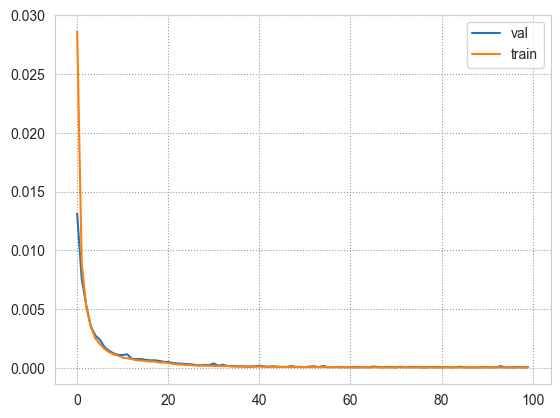

In [144]:
# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) 

# Компиляция модели
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['R2Score'])

# Обучение модели
epochs = 100
batch_size=8
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test))

# выводим графики
sns.lineplot(y=history.history['val_loss'], x=np.arange(epochs), label='val')
sns.lineplot(y=history.history['loss'], x=np.arange(epochs), label='train')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


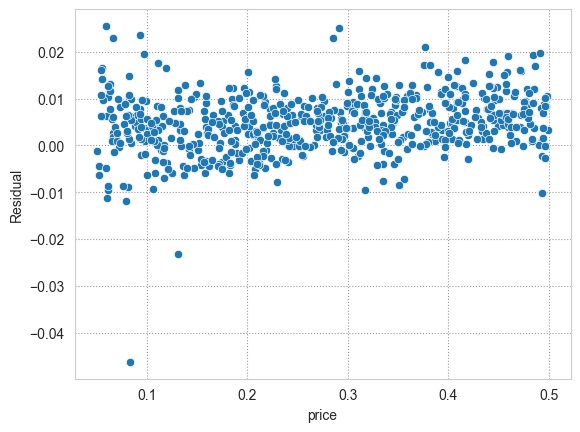

In [145]:
y_pred = model.predict(X_test)
residuals = y_test - y_pred
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()